<a href="https://colab.research.google.com/github/ritika-07/Product-Recommendation-Engine/blob/master/Recommender_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Recommendation Engine


## Initialisation

In [75]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
%matplotlib inline

In [76]:
import os, sys
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [77]:
#Import data set 
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Mise_En_Dataset.xlsx', header = 0)

In [78]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')

dataset dimensions are: (4989, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,product_id,title,selling_price,Customer_id,quantity,OrderID,ordered_date,Rating
count,499.000000,499,499.000000,2841.000000,499.000000,4.990000e+02,499,499.000000
unique,NaN,15,NaN,NaN,NaN,NaN,23,NaN
top,NaN,steel kadayi,NaN,NaN,NaN,NaN,2022-08-24 00:00:00,NaN
freq,NaN,105,NaN,NaN,NaN,NaN,68,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-02 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-29 00:00:00,NaN
mean,5.262525,NaN,491.727455,13243.644843,1.611222,1.269885e+10,NaN,3.150301
std,3.882462,NaN,325.429302,6287.488224,1.201219,1.324400e+10,NaN,1.228614
min,1.000000,NaN,199.000000,1.000000,1.000000,1.289880e+08,NaN,1.000000
25%,2.000000,NaN,289.000000,13491.000000,1.000000,5.561140e+09,NaN,2.000000


In [79]:
#Taking a smaller set of the data to speed up computations
df_sample = df.iloc[:450]

## Data Pre-processing

In [80]:
#Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.Customer_id)==False]

#Create a lookup table
item_lookup = cleaned_retail[['product_id', 'title']].drop_duplicates()
item_lookup['product_id'] = item_lookup.product_id.astype(str)

#Data cleaning' to raw data
cleaned_retail['Customer_id'] = cleaned_retail.Customer_id.astype(int)
cleaned_retail = cleaned_retail[['product_id', 'quantity', 'Customer_id']]
grouped_cleaned = cleaned_retail.groupby(['Customer_id', 'product_id']).sum().reset_index()
print()
grouped_cleaned.quantity.loc[grouped_cleaned.quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('quantity > 0')


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [81]:
#Count number of products and number of customers in the reduced dataset 
no_products = len(grouped_purchased.product_id.unique())
no_customers = len(grouped_purchased.Customer_id.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 13
Number of products in dataset: 13


## Create a Bipartite Graph

In [82]:
#Turn raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'Customer_id', columns='product_id', values='quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1

## Convert to a Weighted Product Graph

In [83]:
#Initialize zeros dataframe for product interactions
products_integer = np.zeros((no_products,no_products))

#Count how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(no_products):
    for j in range(no_products):
        if i != j:
            df_ij = ratings_binary.iloc[:,[i,j]] #create a temporary df with only i and j products as columns
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2]) #if s1_ij == 2 it means that both products were purchased by the same customer
            products_integer[i,j] = pairings_ij
            products_integer[j,i] = pairings_ij

Counting how many times each pair of products has been purchased...


In [84]:
#Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)

Counting how many times each individual product has been purchased...


In [85]:
#Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])

Building weighted product matrix...


## Visualise Weighted Product matrix

In [86]:
#Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.title.values,index=item_lookup.product_id).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

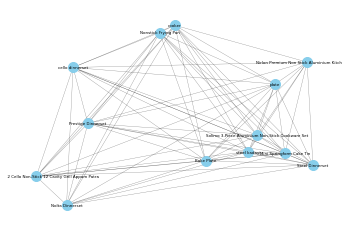

In [87]:
#Create Graph object using the weighted product matrix as adjacency matrix
G = nx.from_numpy_matrix(products_weighted)
pos=nx.random_layout(G)
labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = nodes_labels[idx]

nx.draw_networkx_nodes(G, pos , node_color="skyblue", node_size=100)
nx.draw_networkx_edges(G, pos,  edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show()

#### For better visualisation, export the graph to Gephi

In [88]:
#Export graph to Gephi
H=nx.relabel_nodes(G,labels) #create a new graph with Description labels and save to Gephi for visualizations
nx.write_gexf(H, "products.gexf")

## Louvain Clustering

In [89]:
# function for setting colors of nodes and edges
def get_paired_color_palette(size):
    palette = []
    for i in range(size*2):
        palette.append(plt.cm.Paired(i))
    return palette

#Find communities of nodes (products)
louvain = community_louvain.best_partition(G, resolution = 1.5)
values = list(louvain.values())

communities =[]

for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    communities.append(nodelist)

## Visualise detected communities

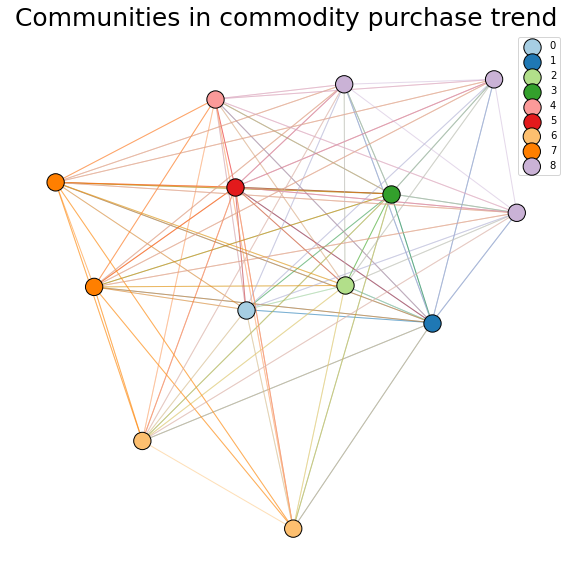

In [90]:
#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)
dark_colors = get_paired_color_palette(clusters_count)
g = nx.drawing.layout.spring_layout(G, weight = 'weight')

#iterate through each of the communities found by the Louvain algorithm and plot
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)                                                                                                           
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

#set title, legend and show plot
plt.title('Communities in commodity purchase trend', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

## Performance Metrics

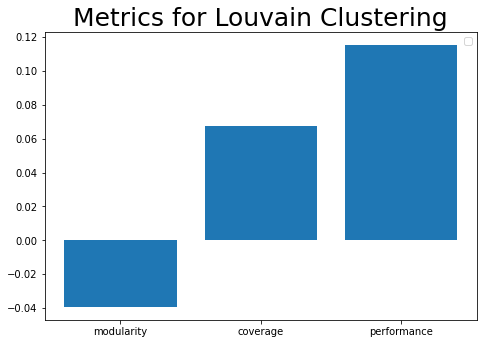

In [91]:
# Transform all the graphs in the same format
clusters = []
for cluster in range(len(set(louvain.values()))):
    cluster_list = []
    for k, v in louvain.items():
        if v == cluster:            
            cluster_list.append(k)
    clusters.append(cluster_list)
louvain = clusters

x = ['modularity', 'coverage', 'performance']
y= [nx.community.modularity(G, eval('louvain')), 
    nx.community.coverage(G, eval('louvain')), 
    nx.community.performance(G, eval('louvain'))] 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.title('Metrics for Louvain Clustering', fontdict={'fontsize': 25})
plt.legend()
plt.show()

## Detected Community Analysis

In [92]:
#Check how many communities were created
print('Number of communities:', len(np.unique(values)))

Number of communities: 9


In [93]:
#Create dataframe with product description and community id
products_communities = pd.DataFrame(nodes_labels, columns = ['product_description'])
products_communities['community_id'] = values

In [94]:
#Community 1
products_communities[products_communities['community_id']==1].head(300)

,product_description,community_id
1,cooker,1


## Product Recommendation

In [95]:
#Turn into dataframe
products_weighted_pd = pd.DataFrame(products_weighted, columns = nodes_labels)
products_weighted_pd.set_index(products_weighted_pd.columns, 'product', inplace=True)

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis = 1), axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
#Saving the trained model for use in the UI
products_prob.to_csv('/content/drive/MyDrive/Colab Notebooks/products_prob.csv')

---
## Testing



In [97]:
#Add item to basket
products_prob = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/products_prob.csv')
basket = ['cooker']
print(basket)
#Select the number of relevant items to suggest
no_of_suggestions = 5

all_of_basket = products_prob[basket]
all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

print('You may also consider buying:', suggestions_to_customer)

recommend_array = []
for recommendations in suggestions_to_customer:
  recommend_array.append(products_prob.loc[recommendations,'Unnamed: 0'])
print(recommend_array)

['cooker']
You may also consider buying: [3, 5, 0, 2, 10]
['Prestige Dinnerset', 'plate', 'steel kadayi', 'Mini Springform Cake Tin', 'cello dinnerset']
